# Direct Dependencies Analysis
This notebook explores the direct dependencies exported in dataset_dependencies.json

Requirements: install networkx, matplotlib and ipywidgets via pip

## Setup and Load

In [21]:
import json
import matplotlib.pyplot as plt
import pandas as pd

INPUT_FILE_NAME = "direct_dependencies.json"
INPUT_DIR = "LTC LCS CF Scripts"

# Load the direct dependencies data
file_path = f"{INPUT_DIR}/{INPUT_FILE_NAME}"
with open(file_path, 'r') as file:
    direct_dependencies = json.load(file)

# Convert to a DataFrame
dependency_list = []
for dataset, dependencies in direct_dependencies.items():
    for dep in dependencies:
        dependency_list.append({"Dataset": dataset, "Dependency": dep})

df = pd.DataFrame(dependency_list)


## Basic Data Exploration

In [22]:
# Display the first few rows of the DataFrame
print(df.head())

             Dataset           Dependency
0  JOINED_LTC_LOOKUP           PCD_REFSET
1  JOINED_LTC_LOOKUP       QOF_PCD_REFSET
2  JOINED_LTC_LOOKUP      QOF_DRUG_REFSET
3  JOINED_LTC_LOOKUP  LTC_LCS_LOOKUPTABLE
4  JOINED_LTC_LOOKUP         PRIMIS_CODES


In [23]:
# DataFrame shape (number of rows and columns)
print(f"DataFrame Shape: {df.shape}")

# Column data types
print(f"Data Types:\n{df.dtypes}")

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing Values:\n{missing_values}")


DataFrame Shape: (319, 2)
Data Types:
Dataset       object
Dependency    object
dtype: object
Missing Values:
Dataset       0
Dependency    0
dtype: int64


## Unique Dataset Count

In [24]:
# Unique Datasets and Dependencies
unique_datasets = df['Dataset'].nunique()
unique_dependencies = df['Dependency'].nunique()
print(f"Unique Datasets: {unique_datasets}")
print(f"Unique Dependencies: {unique_dependencies}")

Unique Datasets: 46
Unique Dependencies: 67


## Frequent dependencies

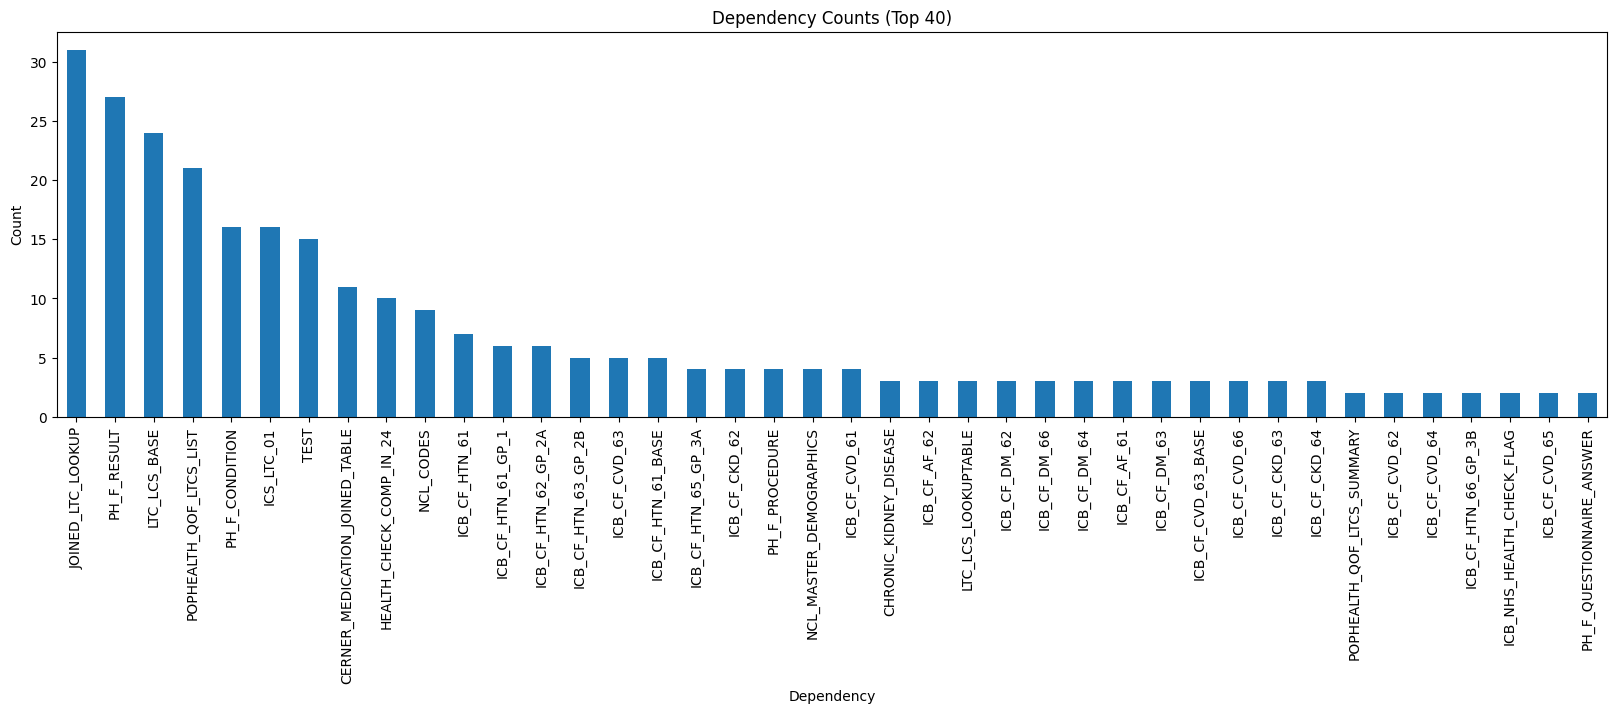

In [25]:
dependency_freq = df['Dependency'].value_counts().head(40)

plt.figure(figsize=(20, 5))
dependency_freq.plot(kind='bar')
plt.xlabel('Dependency')
plt.ylabel('Count')
plt.title('Dependency Counts (Top 40)')

# Set x-axis tick labels and rotation
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [26]:
# Frequency of dependencies
dependency_freq = df['Dependency'].value_counts().head(20)
print("Most frequent dependencies:\n", dependency_freq)

Most frequent dependencies:
 Dependency
JOINED_LTC_LOOKUP                 31
PH_F_RESULT                       27
LTC_LCS_BASE                      24
POPHEALTH_QOF_LTCS_LIST           21
PH_F_CONDITION                    16
ICS_LTC_01                        16
TEST                              15
CERNER_MEDICATION_JOINED_TABLE    11
HEALTH_CHECK_COMP_IN_24           10
NCL_CODES                          9
ICB_CF_HTN_61                      7
ICB_CF_HTN_61_GP_1                 6
ICB_CF_HTN_62_GP_2A                6
ICB_CF_HTN_63_GP_2B                5
ICB_CF_CVD_63                      5
ICB_CF_HTN_61_BASE                 5
ICB_CF_HTN_65_GP_3A                4
ICB_CF_CKD_62                      4
PH_F_PROCEDURE                     4
NCL_MASTER_DEMOGRAPHICS            4
Name: count, dtype: int64


## Datasets that have no dependents
This is datasets that have no other datasets that rely on it

In [27]:
def find_datasets_with_no_dependents(direct_dependencies):
    all_datasets = set(direct_dependencies.keys())
    datasets_with_dependents = set()

    # Identifying all datasets that are dependencies
    for dependencies in direct_dependencies.values():
        datasets_with_dependents.update(dependencies)

    # Datasets with no dependents are those in all_datasets but not in datasets_with_dependents
    datasets_with_no_dependents = all_datasets - datasets_with_dependents

    # Sort the list alphabetically
    return sorted(list(datasets_with_no_dependents))

# Use the function with the direct_dependencies dictionary
datasets_with_no_dependents = find_datasets_with_no_dependents(direct_dependencies)

print(f"Datasets with no dependents: {len(datasets_with_no_dependents)} of {unique_datasets} total datasets ({len(datasets_with_no_dependents)/unique_datasets:.0%})")
for dataset in datasets_with_no_dependents:
    print(dataset)

Datasets with no dependents: 6 of 46 total datasets (13%)
ICB_LTC_CF_TIME_SERIES
ICS_CKD_21_NUMERATOR
ICS_DM_21_NUMERATOR
LTCS_LCS_RIGHTCARE_CF_QOF
LTC_PROTOTYPE_INDICATOR
PATIENTS_ON_LTC_REGISTERS


## Independent Datasets

In [28]:
# Define the variable independent_datasets
independent_datasets = df[df['Dependency'].isnull()]

dataset_list = []
for dataset in independent_datasets['Dataset'].unique():
    dataset_list.append(dataset)

print(f"Total Independent Datasets: {len(dataset_list)}")

for dataset in dataset_list:
    print(dataset)


Total Independent Datasets: 0


## Circular Dependency Detection
Circular dependencies occur when a dataset indirectly depends on itself, which can lead to issues.

In [29]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for dataset, dependencies in direct_dependencies.items():
    for dependency in dependencies:
        if dataset != dependency:  # Exclude self-references
            G.add_edge(dataset, dependency)

# Detect circular dependencies (simple cycles)
circular_dependencies = list(nx.simple_cycles(G))

# Print circular dependencies, if any
if circular_dependencies:
    print("Circular dependencies detected:")
    for cycle in circular_dependencies:
        # Include the start node at the end for full cycle representation
        cycle.append(cycle[0])
        
        if len(cycle) > 6:  # Limit display for long cycles
            cycle_summary = f"{cycle[0]} -> ... -> {cycle[-2]} -> {cycle[0]} (cycle of length {len(cycle)-1})"
        else:
            cycle_summary = " -> ".join(cycle)
        
        print(cycle_summary)
else:
    print("No circular dependencies detected.")


No circular dependencies detected.


## Dependencies and Dependents for a specific dataset

### Dependencies
- **Dependencies** refer to other datasets that the selected dataset **relies on**. 
- In simple terms, dependencies are what a dataset 'needs'.

### Dependents
- **Dependents** are datasets that **rely on** the selected dataset.
- In essence, dependents are what 'need' the dataset.

In [30]:
import ipywidgets as widgets
from ipywidgets import interact

# Function to display dependencies and dependents of a selected dataset
def display_dataset_dependencies(dataset_name):
    # Dependencies
    dependencies = direct_dependencies.get(dataset_name, [])
    print(f"Total Dependencies: {len(dependencies)}")
    if dependencies:
        print("Dependencies - datasets that are relied upon for the selected dataset to run:")
        for dep in dependencies:
            print(f"- {dep}")

    # Dependents
    dependents = [ds for ds, deps in direct_dependencies.items() if dataset_name in deps]
    print(f"\nTotal Dependents: {len(dependents)}")
    if dependents:
        print("Dependents - other datasets that rely on the selected dataset:")
        for dep in dependents:
            print(f"- {dep}")

# Create the dropdown widget for selecting datasets
dataset_dropdown = widgets.Dropdown(
    options=sorted(list(direct_dependencies.keys())),
    description='Select a dataset:',
    style={'description_width': 'initial'}  # Adjust the width of the description
)

# Create the interactive widget
interact(display_dataset_dependencies, dataset_name=dataset_dropdown)


interactive(children=(Dropdown(description='Select a dataset:', options=('ASTHMA_ADULT', 'ASTHMA_CHILD', 'HEAL…

<function __main__.display_dataset_dependencies(dataset_name)>